# Задание 3 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!


# Load data
%%bash
git clone https://github.com/balezz/modern_dl.git
cd modern_dl
mkdir data
cd data
wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz 

%cd modern_dl

In [1]:
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from lib.gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from copy import deepcopy
from lib.data_utils import Dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

In [2]:
# Путь к папке с данными
cifar10_dir = 'data/cifar-10-batches-py'

# Очистим значения переменных, чтобы избежать проблем с излишним потреблением памяти
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

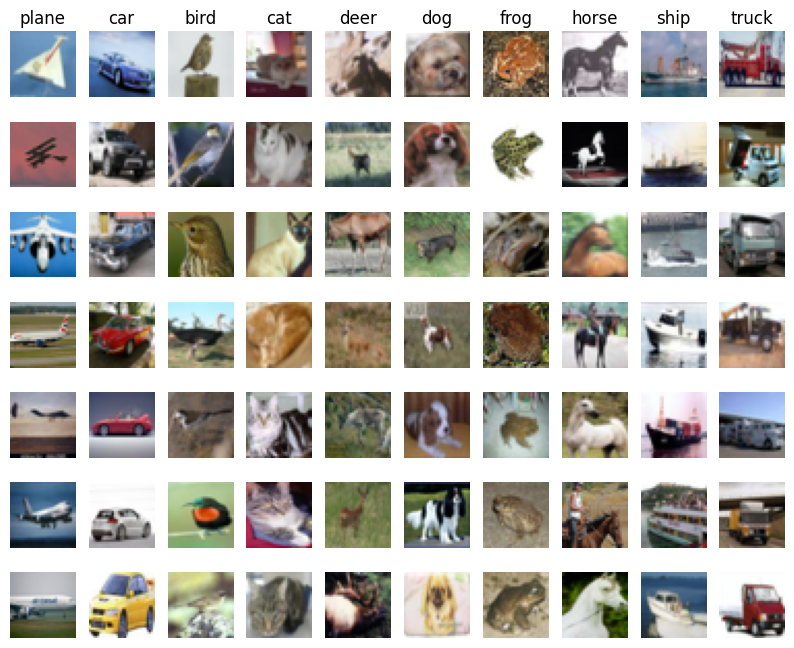

In [3]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Преобразуем двумерные изображения в одномерные вектора
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

[130.71074 136.05614 132.5538  130.14036 135.44238 131.85358 131.05044
 136.24616 132.58144 131.56886]


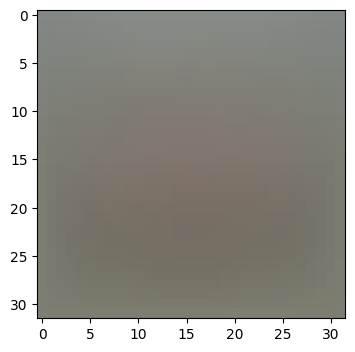

(50000, 3072) (10000, 3072)


In [5]:
# Нормализуем значения яркости пикселей 
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 

# визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычтем средние значения яркости
X_train -= mean_image
X_test -= mean_image

print(X_train.shape, X_test.shape)

# Начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам  


Начнем с ReLU, у которого параметров нет.

In [6]:
class ReLULayer:
    def __init__(self):
        self.mask = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Hint: you'll need to save some information about X
        # to use it later in the backward pass
        raise Exception("Not implemented!")


    def backward(self, d_out):
        """
        Backward pass
        Arguments:
        d_out, np array (batch_size, num_features) - gradient
           of loss function with respect to output
        Returns:
        d_result: np array (batch_size, num_features) - gradient
          with respect to input
        """
        # TODO: Implement backward pass
        # Your final implementation shouldn't have any loops
        raise Exception("Not implemented!")


    def params(self):
        # ReLU Doesn't have any parameters
        return {}

In [7]:
# TODO: Implement ReLULayer 
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

-0.5387082917146381 -0.5387082917085451
-0.0 0.0
-0.2372280833822459 -0.23722808337733878
-0.0 0.0
1.0481019365849216 1.0481019365737865
-2.7654552110595945 -2.765455211062306
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [8]:
class Param:
    """
    Trainable parameter of the model
    Captures both parameter value and the gradient
    """

    def __init__(self, value):
        self.value = value
        self.grad = np.zeros_like(value)

In [9]:
class FullyConnectedLayer:
    def __init__(self, n_input, n_output):
        self.W = Param(0.001 * np.random.randn(n_input, n_output))
        self.B = Param(0.001 * np.random.randn(1, n_output))
        self.X = None

    def forward(self, X):
        # TODO: Implement forward pass
        # Your final implementation shouldn't have any loops
        raise Exception("Not implemented!")



    def backward(self, d_out):
        """
        Backward pass
        Computes gradient with respect to input and
        accumulates gradients within self.W and self.B
        Arguments:
        d_out, np array (batch_size, n_output) - gradient
           of loss function with respect to output
        Returns:
        d_result: np array (batch_size, n_input) - gradient
          with respect to input
        """
        # TODO: Implement backward pass
        # Compute both gradient with respect to input
        # and gradients with respect to W and B
        # Add gradients of W and B to their `grad` attribute

        # It should be pretty similar to linear classifier from
        # the previous assignment
        raise Exception("Not implemented!")

    def params(self):
        return {'W': self.W, 'B': self.B}

In [10]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

0.0007013599515794062 0.0007013599515395818
-0.0017555005106297838 -0.0017555005105834851
0.000758079946694882 0.0007580799467332698
0.00018162456193386673 0.00018162456196131602
0.00037286181338408084 0.0003728618134298672
0.0007699779144748346 0.0007699779144137996
Gradient check passed!
-2.4294637874166813 -2.4294637874167773
-0.15573653839019114 -0.15573653839020749
-0.8115464369201346 -0.8115464369200589
-1.3915259895092151 -1.3915259895091319
4.858927574833363 4.8589275748333804
0.3114730767803823 0.31147307678041497
1.6230928738402692 1.6230928738402912
2.7830519790184303 2.7830519790184374
-2.700151966877956 -2.700151966877895
-1.3750389844903361 -1.3750389844903628
-1.8234308106986648 -1.8234308106987622
0.38629490873010797 0.3862949087300379
Gradient check passed!
-1.0353801684597101 -1.0353801684597126
-0.6590943780892695 -0.6590943780892741
2.3119488397336614 2.3119488397336942
-1.6968751281420542 -1.6968751281420555
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [11]:
# Copied from previous
def softmax_with_cross_entropy(X, y):
    """
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient
    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)
    Returns:
      loss, single value - cross-entropy loss
      dprediction, np array same shape as predictions - gradient of predictions by loss value
    """
    N = X.shape[0]
    X -= np.max(X)
    Exps = np.exp(X)
    # S.shape = N, C
    S = Exps / Exps.sum(axis=1, keepdims=True)
    # loss.shape = 1
    loss = - np.log(S[range(N), y]).mean()
    S[range(N), y] -= 1
    d_out = S / N
    return loss, d_out

def l2_regularization(W, reg_strength):
    loss = reg_strength * np.linalg.norm(W)
    grad = 0.5 * W * reg_strength
    return loss, grad

In [12]:
class TwoLayerNet:
    """ Neural network with two fully connected layers """

    def __init__(self, n_input, n_output, hidden_layer_size, reg):
        """
        Initializes the neural network
        Arguments:
        n_input, int - dimension of the model input
        n_output, int - number of classes to predict
        hidden_layer_size, int - number of neurons in the hidden layer
        reg, float - L2 regularization strength
        """
        self.reg = reg
        # TODO Create necessary layers
        raise Exception("Not implemented!")


    def compute_loss_and_gradients(self, X, y):
        """
        Computes total loss and updates parameter gradients
        on a batch of training examples
        Arguments:
        X, np array (batch_size, input_features) - input data
        y, np array of int (batch_size) - classes
        """
        
        # Before running forward and backward pass through the model,
        # clear parameter gradients aggregated from the previous pass
        # TODO Set parameter gradient to zeros
        # Hint: using self.params() might be useful!
        # raise Exception("Not implemented!")
        X = X.copy()
        for param in self.params().values():
          param.grad = np.zeros_like(param.grad)

        # TODO Compute loss and fill param gradients
        # by running forward and backward passes through the model
        for layer in self.layers:
          X = layer.forward(X)
        
        # After that, implement l2 regularization on all params
        # Hint: self.params() is useful again!
        # raise Exception("Not implemented!")

        loss, d_out = softmax_with_cross_entropy(X, y)

        for layer in reversed(self.layers):
          d_out = layer.backward(d_out)
          reg_grad = 0
          for param in layer.params().values():
            reg_loss, reg_grad = l2_regularization(param.value, self.reg)
            param.grad += reg_grad
            loss += reg_loss 

        return loss

    def predict(self, X):
        """
        Produces classifier predictions on the set
        Arguments:
          X, np array (test_samples, num_features)
        Returns:
          y_pred, np.array of int (test_samples)
        """
        # TODO: Implement predict
        # Hint: some of the code of the compute_loss_and_gradients
        # can be reused
        pred = np.zeros(X.shape[0], int)
        for layer in self.layers:
            X = layer.forward(X)
        pred = np.argmax(X, axis=1)
        # raise Exception("Not implemented!")
        return pred

    def params(self):
        result = {}
        name = 0
        # TODO Implement aggregating all of the params
        for layer in self.layers:
          params = layer.params()
          for p in params.values():
            result[f'p{name}'] = p
            name += 1

        return result

In [13]:
# TODO: implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = X_train.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(X_train[:2], y_train[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, X_train[:2], y_train[:2])

Checking gradient for p0
-0.006176590936756828 -0.006176590927609026
0.020147271991041073 0.02014727198407229
0.013044456879705787 0.013044456848021467
-0.010858802494877052 -0.010858802479418726
0.019263256849400338 0.01926325685630559
0.022932906252011026 0.022932906240669123
-0.014439784924933188 -0.014439784923325759
0.016631486377790727 0.016631486388085648
0.030495649417965058 0.0304956494279196
0.0010980731054104085 0.0010980730991150267
0.0274453115020177 0.027445311512330758
-0.0023190409436134275 -0.0023190409592643846
-0.00041309949628760546 -0.0004130994879503191
0.027639913391070633 0.02763991338028404
0.0008724324828254368 0.0008724325040176949
-0.0010996802900559 -0.001099680302374395
0.026599336843732908 0.026599336822030747
0.002322435186654695 0.00232243519970865
0.006908888972965544 0.0069088889942392475
0.027554907206114077 0.02755490720041109
-0.014591010675193748 -0.014591010688569382
0.008552068189423386 0.008552068164746629
0.030355912359686658 0.030355912361557

0.03355584058382913 0.03355584057285199
0.013837511124279266 0.013837511114722643
-0.009981486543791747 -0.009981486548404916
0.031153834623185682 0.03115383460094989
0.02108008643425257 0.02108008643197934
-0.004151999752302251 -0.004151999744017587
0.03874649806742086 0.03874649809887387
0.008768685232357992 0.008768685222371175
-0.0049172583343428345 -0.004917258356051946
0.04007160148263195 0.040071601481450614
0.010384849015497351 0.010384849025157905
-0.0062416050034226015 -0.0062416050106151024
0.038375047327619836 0.038375047317629196
0.013181761292104075 0.01318176130471471
0.001383584418653351 0.0013835844026033326
0.035332800474904655 0.0353328004409903
-0.0029220175778765494 -0.0029220175612465478
0.002698982835267984 0.0026989828372236953
0.04043256241729499 0.04043256240926496
-0.005700031874250275 -0.005700031890931711
0.003474897634974508 0.003474897636301932
0.041919148320281145 0.041919148308089405
-0.0073387007209865926 -0.00733870071378817
0.0017430792679862083 0.00

0.03403611762635049 0.034036117613212014
-0.026219306462382606 -0.026219306503705294
0.013934115836457346 0.013934115838942772
0.005277051580401017 0.005277051573493452
-0.02942771749766102 -0.029427717507246594
0.014887277111786258 0.014887277144381981
0.020078118778740082 0.020078118767585806
-0.03144071646144894 -0.0314407164747621
0.014721196060846221 0.014721196062161821
0.03131917839529284 0.0313191783840594
-0.03108996681173018 -0.031089966801012277
0.017753396541705345 0.01775339653065089
0.006095677092736743 0.006095677118622688
-0.037493727207745416 -0.03749372718964139
0.01845935902753505 0.018459359019118438
0.02052209171527136 0.02052209171488073
-0.038984662466270206 -0.038984662431573724
0.01909944285561906 0.019099442871706174
0.031121276036999396 0.031121276045098508
-0.04033646736647022 -0.04033646736623098
0.012516483502822556 0.012516483494096063
0.0037497298191377115 0.003749729815538671
-0.02643379349707219 -0.026433793487434794
0.013255051150420596 0.013255051167

-0.02896358370333127 -0.028963583709185056
0.013566870149120976 0.013566870160630627
0.06116872925022208 0.06116872923733751
-0.02607918586321962 -0.026079185877492247
-0.006910792872637893 -0.006910792871295256
0.05507711599065772 0.05507711600127862
-0.02493798928860852 -0.024937989273610125
0.006311566614745423 0.006311566602690276
0.05266700179316501 0.052667001826378616
-0.02525697565893947 -0.02525697566646556
0.0148359606997076 0.014835960704395744
0.0533406750209376 0.053340675010282716
-0.024201447860596543 -0.024201447867966405
-0.004686138513678997 -0.004686138543874563
0.05111148629987836 0.05111148630998485
-0.023604588282268545 -0.023604588261783018
0.008021843453366187 0.00802184345616297
0.04985096749388033 0.049850967509534876
-0.02393172726910151 -0.02393172724435288
0.016844496922070757 0.01684449690841916
0.05054185838354865 0.05054185836517177
-0.02687077469139945 -0.02687077469420984
-0.0034512873907308495 -0.0034512874114156484
0.05674888710863797 0.0567488871006

0.033416535581494516 0.033416535583086215
-0.01757817628566902 -0.01757817629233216
0.0180872732016076 0.018087273212508137
0.03712367630139269 0.037123676288608465
-0.018080715872689945 -0.018080715880053333
-0.002864374626275009 -0.002864374626376786
0.03818499896957018 0.038184998962798034
-0.01716780316861501 -0.017167803156858952
0.010943845869376965 0.01094384587396746
0.036257001709402915 0.03625700171205892
-0.019714877881565854 -0.01971487786356363
0.020129367016157394 0.02012936699546941
0.041636216004582054 0.04163621598607392
-0.01338505276255337 -0.01338505275505497
-0.004444895826993132 -0.004444895851385411
0.02826814101524306 0.02826814100576058
-0.012715541012313716 -0.012715541020114072
0.008994428063249132 0.008994428091213535
0.026854186740809076 0.026854186763181073
-0.01658778985574597 -0.016587789852806623
0.01865644894525788 0.018656448941278825
0.035032060843665704 0.0350320608299981
0.003001669276834636 0.0030016692464940316
-0.0004205400526849691 -0.000420540

0.0027573687850699817 0.0027573687999549175
-0.0050287375412543574 -0.005028737537493555
0.027788642830705024 0.027788642853465714
0.01062028401879137 0.010620284007778478
0.026641196586363308 0.02664119658213337
0.011800572525577554 0.011800572519149453
-0.056264036853483954 -0.05626403685177194
0.02176747014768222 0.02176747013749036
0.023361531390129597 0.023361531376053787
-0.04597112365527899 -0.045971123641130866
0.018050476401851933 0.01805047638026025
0.03294824027241418 0.03294824026944809
-0.038121135670632224 -0.03812113569257036
0.0006598845550859944 0.0006598845692096234
0.0037956547712337373 0.0037956547682682635
-0.0013936224225531842 -0.00139362243967156
-0.0010399492461851882 -0.0010399492600399185
0.017060786536011376 0.017060786539069284
0.002196288088015776 0.00219628806252814
-0.0044775156417704715 -0.00447751564713883
0.026139147072801003 0.026139147069059728
0.009456148272618328 0.00945614826441954
-0.028831943081114475 -0.028831943099660858
-0.002385618510192515

0.011615008404170476 0.011615008421728133
0.022769680128730006 0.022769680141365708
-0.0147799829500407 -0.014779982948631696
0.022017577979273863 0.022017577983035604
0.031214119932608874 0.03121411993323164
-0.0024886219908608702 -0.0024886219973652146
-0.003150505412577083 -0.0031505054121083727
0.005255766908002094 0.00525576691057239
-0.007659041080186496 -0.007659041090235518
0.010756327199568571 0.010756327206706827
0.016175270814169727 0.016175270811658038
-0.012739128966500117 -0.012739128973926482
0.020451449116511405 0.02045144911200225
0.02690400257844759 0.026904002581318306
0.0023962539597832933 0.0023962539286159767
0.0002149743011803598 0.00021497430502392942
-0.005060693151168937 -0.005060693131220262
-0.0026129533706965337 -0.0026129533647889502
0.013744907357033456 0.013744907367829738
0.005518344653503922 0.005518344647903461
-0.009550246547545185 -0.009550246549139274
0.022488955840189163 0.02248895585310606
0.020169342693337703 0.020169342707099247
0.0096737451617

0.013724757493363755 0.013724757486066606
0.002785441708510358 0.0027854416995154447
-0.028985569732517785 -0.028985569722195233
0.0147535996615039 0.014753599653083425
0.01583751772536132 0.01583751771949693
-0.031158400576545474 -0.031158400570774344
0.016256858337488835 0.01625685832618018
0.024638768915361806 0.024638768891804826
-0.03433316043658979 -0.03433316042578127
0.01121771918207672 0.01121771917578229
0.006751179468675164 0.006751179459918432
-0.02369090905606935 -0.023690909056739425
0.012076512727940771 0.012076512723169229
0.02016676195986671 0.020166761949269585
-0.025504611062936493 -0.025504611067539425
0.014649493347850547 0.014649493351726049
0.02996804461202336 0.02996804460142499
-0.03093853652317668 -0.030938536510483058
0.008170550136631573 0.008170550147568179
0.009587683834214865 0.009587683802436686
-0.017255536271069207 -0.017255536266524985
0.008601906826152732 0.008601906831273709
0.022666061754131762 0.022666061760823194
-0.01816652645867355 -0.018166526

0.026265195527409933 0.02626519552961781
0.008414843796898682 0.008414843799542382
-0.006514529355729101 -0.006514529360401865
0.030817250481831978 0.03081725048481587
0.013758155290271796 0.013758155303911222
-0.011796915642023629 -0.011796915644346482
0.005106227330561761 0.005106227329854107
0.024914124794980307 0.02491412478544674
-0.012750962725391475 -0.012750962730123659
0.020122898536613514 0.02012289854746996
0.026928994513183712 0.026928994500963196
-0.01529181556511078 -0.015291815569362653
0.02652231066938108 0.026522310658805278
0.032295068718965515 0.032295068708165786
-0.021840382227341824 -0.021840382236071317
0.0004453514530060033 0.0004453514446112194
0.046125108027705114 0.04612510804413716
-0.023048677434842044 -0.02304867741109717
0.015076686166137963 0.015076686166182183
0.048676929071639716 0.04867692904308995
-0.025326084598695394 -0.025326084607257823
0.022496605382854595 0.02249660537856357
0.053486627471711644 0.053486627482612896
-0.026857445136897452 -0.026

0.021473010581974147 0.021473010569650338
0.0042783251668504566 0.0042783252052203125
-0.04534924904078288 -0.04534924904486814
0.019442526387152794 0.019442526388857573
0.018595402881048446 0.0185954028841806
-0.041061031835617164 -0.041061031841316264
0.01680088238362643 0.016800882374212733
0.028880057246903387 0.028880057234559327
-0.03548209490287179 -0.035482094906669204
0.025767858815093567 0.025767858824465858
0.006128332577100868 0.006128332574739658
-0.054419618627411785 -0.054419618611412084
0.02281113236169527 0.022811132360800453
0.019973450958240005 0.019973450982035956
-0.048175253228868634 -0.048175253231086394
0.019922984424077483 0.01992298443997953
0.030195121292114466 0.030195121292209134
-0.04207572006887468 -0.042075720085854584
0.030140392943651263 0.03014039295923254
0.009649157262047434 0.00964915725099047
-0.06365405449649034 -0.06365405449404449
0.025203121712716284 0.0252031217229387
0.021735038983001203 0.021735038968628825
-0.053226939873749886 -0.05322693

-0.028155111601756995 -0.028155111619909686
0.01651689869143267 0.01651689867099293
0.033108885151764106 0.033108885166832636
-0.03488234447981621 -0.0348823445017743
0.008706676169775348 0.008706676180025852
0.011021463161253693 0.01102146316434016
-0.018387790777323394 -0.018387790778895408
0.008852500329094555 0.008852500332778845
0.02273524390507082 0.0227352439097217
-0.018695759522175635 -0.018695759518294608
0.010718351530428733 0.010718351539651392
0.031464806672865754 0.03146480667126639
-0.022636285256996392 -0.02263628524623584
0.01154569623879083 0.011545696221304523
0.004142104698919362 0.0041421047036749314
-0.024383569881052926 -0.02438356989653556
0.01181150760558711 0.011811507594217117
0.01572712170117634 0.015727121693842605
-0.024944941833285585 -0.024944941823257235
0.013724831752720316 0.013724831759986953
0.024528634098905395 0.024528634101628196
-0.02898572656222927 -0.028985726552299692
0.01402533815174804 0.014025338157530596
0.012559462222499136 0.01255946222

0.0580133154553007 0.058013315440419426
-0.029213561914461613 -0.029213561925089945
0.011324312545349604 0.01132431253214605
0.06169666286754334 0.06169666284527863
-0.03110667690813177 -0.031106676900982674
0.011250660921892676 0.011250660936212851
0.06569476751072073 0.06569476749263004
-0.020947323292666405 -0.020947323275954943
0.008943019481418214 0.008943019480511794
0.044239040311113496 0.04423904029771108
-0.020246033842060054 -0.020246033849424805
0.019324351145504542 0.019324351141492002
0.042757974122289516 0.042757974139107084
-0.019492497629875993 -0.019492497616013793
0.02201948193945387 0.022019481926704994
0.04116656702931907 0.041166567021910794
-0.005361605107021732 -0.00536160511543926
0.014859534265940845 0.014859534269717754
0.011323273200487942 0.011323273163554857
0.001498712942515683 0.0014987129759447269
0.026499441012595198 0.0264994410192898
-0.003165159641277452 -0.0031651596232862285
0.006749501872595152 0.006749501868519302
0.031972572743058876 0.031972572

0.011719514205828027 0.01171951418132977
0.022191224940068578 0.022191224924306138
3.827008982569346e-05 3.8270075997104414e-05
0.011861388053261692 0.011861388049538844
-8.082331202199531e-05 -8.082330360537071e-05
-0.007182189926294582 -0.007182189931675963
0.017691347651539444 0.017691347675707902
0.0151682000240411 0.015168200029336274
-0.018747029166357895 -0.018747029173482588
0.02066438477348476 0.020664384781099443
0.0395921983642884 0.039592198364246656
-0.001203860863065812 -0.0012038608776521187
0.019918517619006537 0.019918517590866713
0.002542456069734966 0.0025424560901043947
-0.010357939047618411 -0.010357939039806752
0.024370977589694476 0.024370977591559036
0.02187512345446402 0.02187512346818465
-0.022159877804689157 -0.022159877799410307
0.026052822236202422 0.026052822255095972
0.046799856659213546 0.04679985667888075
0.006563529922577308 0.006563529897363195
0.02299348315481231 0.02299348316192606
-0.01386164049560226 -0.013861640502099702
-0.003458581793490953 -0.

0.02209952616476722 0.022099526142405065
0.009887098739458833 0.00988709876192928
-0.04667239891227156 -0.04667239890121521
0.019192999036401547 0.019192999056727444
0.015111066892442664 0.0151110668644705
-0.04053405039868701 -0.04053405042725444
0.00726931206425537 0.007269312063407084
-0.0066877660905029996 -0.00668776609646926
-0.01535219488197061 -0.015352194893125668
0.0014023296019442734 0.0014023296079912482
0.003678437043672447 0.0036784370660569716
-0.0029616058779022934 -0.0029616058938586316
-0.00657511438220022 -0.006575114408491344
0.009292963866567073 0.00929296386509293
0.013886105930592701 0.013886105909577394
0.0054352756929661695 0.005435275696186181
-0.007603724889256357 -0.007603724871962924
-0.011478859476395584 -0.011478859462954459
-0.000599315441334143 -0.0005993154417183177
0.002819067262730801 0.0028190672685113323
0.0012657053885990338 0.0012657053849451927
-0.012299731049511774 -0.012299731055875894
0.007139703020139727 0.0071397030065867275
0.0259760299735

-0.014241818120467502 -0.014241818124816062
-0.01758061093171614 -0.01758061094481178
0.0019315811014175956 0.001931581072867061
0.037128818075504694 0.03712881808670687
-0.015479819038954441 -0.015479819026609219
0.014433987855961805 0.014433987849393757
0.032692116739936807 0.0326921167470573
-0.009368215647664619 -0.009368215625471521
0.02493914845024512 0.024939148435265675
0.019784908262018074 0.01978490824505741
-0.020038632763435718 -0.020038632753127672
-0.0008619315200094257 -0.0008619315261526593
0.04231995994025593 0.042319959936421014
-0.019878593241575572 -0.019878593260358457
0.01118400934379949 0.011184009340858834
0.04198196950777805 0.04198196952298616
-0.012190930483676057 -0.012190930487321337
0.024388448765712775 0.024388448771617274
0.025746252041956116 0.02574625201923197
-0.012406378094007332 -0.012406378080420664
-0.006689009175434738 -0.006689009168781012
0.02620125984344048 0.026201259850644473
-0.012324592021239152 -0.012324592013612799
0.006791408497100142 0

-0.01505505021520785 -0.01505505018428721
0.0007894545925441674 0.0007894545905884341
0.03179503958816494 0.031795039623361276
-0.0130026064678046 -0.01300260648040563
0.0144610469768049 0.014461046937697118
0.027460445596890964 0.027460445606308777
-0.0035321622073595693 -0.0035321622071649013
0.026950686582659377 0.026950686593529834
0.007459638832780013 0.007459638862172823
-0.017532246873638427 -0.017532246876506008
-0.010109120332848467 -0.010109120340828781
0.03702667712484404 0.03702667710214769
-0.015549988826661183 -0.015549988829910431
0.003456099146016926 0.0034560991402088344
0.03284030961516052 0.03284030962724671
-0.009011669955635024 -0.009011669943603806
0.016782294409446806 0.016782294398609565
0.01903191280660477 0.019031912801281692
-0.01284373918293011 -0.012843739183310275
-0.00766248568961586 -0.00766248566819172
0.02712493083342998 0.027124930856992076
-0.011733805797429574 -0.011733805793667782
0.005201876123517752 0.005201876129845573
0.024780841944469188 0.024

0.00418366606363412 0.004183666080237458
-0.011674962759390044 -0.011674962729912862
-0.008835561902180778 -0.008835561882136744
-0.004012386857735079 -0.0040123868449981615
-0.0001794494263326241 -0.00017944943309089465
0.008473834172658604 0.00847383418989267
-0.016225027594724592 -0.01622502758813482
-0.029560373308883014 -0.02956037330470451
0.03426593650097731 0.0342659364882536
-0.02126457517659777 -0.021264575189583464
-0.019803808819695876 -0.01980380881505539
0.044909050444910864 0.04490905043397219
-0.024158388042272914 -0.024158388045592002
-0.008658877928018107 -0.00865887794798681
0.05102054747146608 0.05102054747574413
-0.024465678563946103 -0.02446567857194992
-0.03428445460208781 -0.03428445460862406
0.051669520019680996 0.05166952004032054
-0.028378303280386423 -0.02837830330726376
-0.022819934523301402 -0.02281993454200659
0.05993266467709223 0.0599326646755216
-0.028100201990079936 -0.02810020198751317
-0.010905675581573985 -0.010905675584815809
0.059345337407610096 

0.02585883533435947 0.02585883533967603
0.015473547472287217 0.015473547465560953
0.008626863274195687 0.008626863268190732
0.017112807879962423 0.017112807881858316
-0.018219232443852148 -0.018219232456040402
0.0026173452812129163 0.0026173452738476044
0.022603753869876852 0.022603753868644102
-0.005527620010725581 -0.005527620028367152
-0.0074427713126933364 -0.007442771310373074
0.02506179817364042 0.025061798192282932
0.015718526683736862 0.015718526702457325
0.005277501081481021 0.005277501080591662
0.015142694677183688 0.015142694675951416
-0.011145652350117765 -0.011145652356603362
-0.0004503564763202757 -0.00045035648543745305
0.022924215604902626 0.02292421559246804
0.0009511161894980064 0.0009511162080144685
-0.00940941367783457 -0.009409413670447009
0.0258085553129726 0.02580855531508774
0.019871915145521186 0.019871915157843034
-0.00011230136407341007 -0.0001123013460002653
0.006352720873161981 0.0063527208826741335
0.00023717133224252757 0.00023717134922662805
-0.007148911

-0.014725052243147437 -0.014725052288611094
0.015577906581266357 0.015577906564701037
0.03109811075460474 0.031098110775396034
-0.01924639151376613 -0.01924639154715635
-0.02637414346676983 -0.026374143469176655
0.040646810961239115 0.04064681093929323
-0.022234068206129495 -0.022234068208781817
-0.01754577985009048 -0.017545779851246834
0.04695654074310152 0.04695654074460264
-0.02537230574391246 -0.025372305745285924
-0.009256220514012588 -0.009256220523390368
0.053584242764983955 0.05358424277623896
-0.026775770453164104 -0.02677577044529755
-0.026603456676315418 -0.026603456682039447
0.05654824589704739 0.05654824588585682
-0.030467569060162507 -0.030467569089864806
-0.019152870220593365 -0.019152870223138052
0.06434502380101441 0.0643450237980403
-0.03305312603252921 -0.0330531260361866
-0.010025672488915964 -0.010025672492197657
0.06980550949310549 0.06980550950608233
-0.02717076127493128 -0.027170761285333352
-0.014156253808468973 -0.014156253813624174
0.057382434334516896 0.057

0.017096768592443037 0.01709676860084386
-0.009165874813765677 -0.009165874814698327
0.0038133502379080874 0.0038133502355819355
0.019357580904609435 0.01935758091597961
-0.014706121411465118 -0.014706121431729
0.012811059166507368 0.01281105916906
0.0310581303803003 0.031058130400829494
-0.015180850869455401 -0.015180850865270655
-0.012447055813341582 -0.012447055808273431
0.03206072032152958 0.03206072032302387
-0.016257441803861784 -0.01625744179278854
0.0011414271733604178 0.0011414271749998761
0.03433439267003711 0.034334392662316304
-0.019660148735783246 -0.019660148731226457
0.01213631300200989 0.012136312999011521
0.04152063250722336 0.04152063250995042
-0.025105953344661265 -0.02510595333848897
-0.011337462285910115 -0.011337462280103237
0.05302172819628196 0.05302172818577588
-0.02618240636883404 -0.026182406376307196
-0.0011655399732143446 -0.001165539975644947
0.05529510928961103 0.05529510929136449
-0.029044690833410925 -0.02904469083020444
0.007852867135268652 0.007852867

-0.04047370795724314 -0.040473707940691384
0.039518141134104415 0.03951814111502472
-0.009011171357098141 -0.009011171320238986
-0.029498648442457878 -0.02949864843504457
0.019030859807113422 0.019030859799151756
-0.018741194502628403 -0.018741194485194512
-0.016600623415503342 -0.016600623431450856
0.03957987602981519 0.03957987604330526
-0.017034093892894123 -0.01703409386877297
-0.009664738949698768 -0.009664738964687558
0.03597461861176595 0.03597461859516926
-0.006824503822717861 -0.006824503850921814
0.007672529451659262 0.007672529456215215
0.014412796112344394 0.014412796112139857
-0.019982561644995324 -0.019982561627607254
-0.006989259092750011 -0.006989259082601506
0.04220154230596839 0.04220154230516471
-0.018001836523307006 -0.01800183653255516
0.0016037902750203606 0.0016037903005639007
0.038018412209614647 0.03801841221839908
-0.008596565456720372 -0.008596565459484395
0.016168961876061552 0.016168961880502764
0.018155245921569443 0.018155245928852537
-0.01515044696718500

-0.030403798717344513 -0.030403798723099836
0.05102311275746095 0.05102311275706483
-0.024186558859606837 -0.02418655884461884
-0.023300498438925975 -0.023300498441791714
0.05108004194272718 0.05108004192955206
-0.02307661486562679 -0.023076614863448693
-0.04367197116556566 -0.043671971172720696
0.04873593064952189 0.04873593066889725
-0.025861818118097367 -0.02586181813146737
-0.04292335687851069 -0.042923356868840294
0.054618053020919446 0.05461805301365529
-0.0272088669333246 -0.02720886691509605
-0.04061631768849239 -0.04061631768692564
0.0574629103807492 0.05746291036334838
-0.023884164151226663 -0.023884164135345994
-0.044585271198330695 -0.04458527120831945
0.050441408953347505 0.050441408960821825
-0.027731207247347515 -0.02773120724164357
-0.04699905030749218 -0.04699905029603712
0.058566050571279865 0.058566050564756715
-0.028835523442948482 -0.02883552343568851
-0.046809050844912936 -0.04680905085763242
0.06089827641277963 0.060898276421639246
-0.02361393435271523 -0.0236139

-0.010818484968506277 -0.010818484952324068
-0.017638873953006215 -0.017638873961445256
0.02284775892080115 0.022847758907040824
-0.007765879077313202 -0.007765879095344984
-0.015497291455760231 -0.015497291472321704
0.01640090396049643 0.016400903968261105
-0.0037470634809961744 -0.003747063481718271
-0.0010197890714586232 -0.0010197890754071182
0.007913492815672796 0.007913492794386912
-0.009618050644321604 -0.009618050622606233
-0.02016812093308139 -0.020168120928865108
0.020312539422038634 0.020312539428246623
-0.0023952673711890374 -0.0023952674066407553
-0.016676096630911776 -0.01667609661470948
0.005058609556430747 0.005058609575669948
0.0034698479987286214 0.003469847986714569
0.0015314897069739668 0.0015314897350293675
-0.00732803630060614 -0.00732803631109391
-0.015328112477747959 -0.015328112468182551
-0.0384513247551536 -0.03845132474644686
0.03237172484151112 0.03237172485626161
-0.00895164717857784 -0.008951647179067379
-0.03468889630500892 -0.03468889633317929
0.01890514

-0.018146949914499163 -0.01814694992052779
-0.03433691648828614 -0.034336916487909264
0.0383248798700856 0.038324879891860064
-0.01565860904834526 -0.01565860905383687
-0.024663913193096954 -0.024663913178457616
0.033069706674562674 0.03306970668415232
-0.020164475851601298 -0.020164475844630658
-0.02403819988115086 -0.024038199875064944
0.042585730290598554 0.04258573029769507
-0.02223111374458647 -0.022231113749882066
-0.01940499464901173 -0.019404994655580765
0.04695030116100917 0.046950301180181946
-0.01917039236656965 -0.01917039238463758
-0.023774036335672533 -0.02377403631736996
0.040486306953664446 0.040486306951414974
-0.02423108795234235 -0.024231087936144032
-0.02274675553522662 -0.022746755545810512
0.051174083759002266 0.05117408377053322
-0.02654947036829598 -0.02654947035551913
-0.017563246078416438 -0.01756324605750592
0.05607031855344286 0.05607031856591504
-0.023480569852578365 -0.023480569844025464
-0.02098804524815347 -0.020988045257297472
0.049589050673591144 0.049

-0.007428485730807296 -0.007428485737648315
0.002229483357675224 0.002229483353488604
0.008659450002289626 0.008659450001502478
-0.004708487225557885 -0.004708487244542425
-0.0016507695835459334 -0.0016507695654865982
0.016135031951170754 0.016135031954966905
0.0034862908797715277 0.0034862909004118588
0.002937493280050003 0.0029374932708492447
-0.0026921126820139765 -0.002692112688329473
-0.006203746503270555 -0.006203746516497687
0.0021984482508740954 0.0021984482456716137
0.009233644286832828 0.00923364429361584
-0.004642943608282663 -0.004642943607358063
-0.0019375963482478836 -0.0019375963500323221
0.01694278122760928 0.016942781244644323
0.004092045640352236 0.004092045657877463
0.004850435521920915 0.0048504355198986104
-0.002899026460681001 -0.0028990264411277162
-0.010243724679412357 -0.010243724690717215
0.0038529201937683765 0.003852920205105192
0.007703148640660879 0.00770314865228272
-0.008137053569383552 -0.008137053564283292
-0.0005381628612093383 -0.0005381628476186506


0.0031539575190290825 0.0031539575173766816
-0.0050924679818996465 -0.00509246800284302
-0.0167259524988146 -0.01672595248969344
0.01075487751760556 0.010754877544094653
0.008744723481531371 0.008744723500875295
-0.010974567896780064 -0.010974567898891506
-0.01846814360021096 -0.018468143592187403
0.005550091266683017 0.0055500912754524725
-0.0030810953239605687 -0.0030810953344229115
-0.011721340614583844 -0.01172134060922758
0.0009032642919622678 0.0009032642855899552
0.0035432883677131875 0.0035432883516151033
-0.0019076205997974867 -0.0019076205948209688
-0.008948920799344243 -0.008948920804385807
-0.01294168438221534 -0.012941684390810336
0.018899391700406533 0.018899391696081125
-0.008836142053692965 -0.008836142040280492
-0.00034614073307757785 -0.0003461407382943093
0.01866121217716165 0.018661212175530295
-0.014247469104169458 -0.014247469093398022
0.009778803944422052 0.009778803944371361
0.030089494071605837 0.030089494074125863
-0.00888319596455142 -0.008883195978803826
-0.

-0.01121275685014094 -0.011212756856338045
0.04505700807556736 0.045057008102311606
-0.017500272916400827 -0.017500272897486013
-0.004780198602547301 -0.0047801985925133295
0.03695915073193085 0.03695915073986811
-0.009296730408498866 -0.009296730407726272
0.016039643562785057 0.016039643546683635
0.019633937260476773 0.019633937275997937
-0.007915628374050425 -0.00791562837498816
-0.008269480101059212 -0.008269480100686621
0.01671716227581246 0.01671716227669151
-0.009380192621029336 -0.009380192622643335
0.003177916398445374 0.0031779163967016184
0.019810202654054903 0.019810202656067588
-0.017716733636525133 -0.017716733635708692
0.009180044813582384 0.009180044835410683
0.03741629813876466 0.037416298148684746
-0.010726695099561902 -0.010726695087726055
-0.004764525456935076 -0.004764525440847933
0.02265390619529308 0.02265390617317564
-0.01633318104331031 -0.016333181052097245
0.00817079217283995 0.008170792153983086
0.034494347773621606 0.03449434775593119
-0.028604608669494304 -

0.03861362577315964 0.038613625785721695
-0.0006808522148338814 -0.000680852196843773
-0.00320620234170563 -0.0032062023258561108
0.001437904411801005 0.001437904439960391
-0.005755980636977438 -0.005755980647670355
0.010534436643184531 0.010534436634124233
0.012156162191776643 0.012156162187970663
-0.016989898967263124 -0.01698989895437819
0.017115169203047263 0.01711516921520939
0.035881282529192524 0.03588128252296485
0.0026073096595981937 0.0026073096570655707
-0.005056228984582427 -0.005056228946642705
-0.005506425595431659 -0.005506425626577992
-0.0024004973515865634 -0.0024004973564473175
0.008165210958041553 0.008165210951815993
0.005069654848967646 0.005069654829270576
-0.011203864507839058 -0.011203864502817849
0.015012898412062752 0.015012898391120187
0.023661649112756606 0.02366164912892543
0.019041796377971702 0.019041796361918273
0.00028298027356586024 0.00028298026144568666
-0.04021472270187492 -0.040214722663023394
0.0175556650921527 0.017555665077217952
0.0151144596252

-0.0032311087863786422 -0.0032311088027370256
0.009696388986356911 0.009696388980628967
-0.0018600801884817374 -0.0018600802009771653
0.0024613390827837945 0.0024613390881000896
0.0039283378258145275 0.003928337855008124
0.0026563844858029546 0.002656384490151708
0.020488613402434783 0.02048861338366237
-0.005610067630473596 -0.00561006761046201
-0.008622895702859635 -0.00862289570857655
-0.0049927930324080855 -0.004992793045666133
0.018210853256410364 0.01821085326980665
-0.00545482181645996 -0.005454821838668521
-0.005782362396949252 -0.0057823623889063916
0.011520139296880835 0.01152013928695794
0.0001189687934442923 0.00011896879037465168
0.022544618880493302 0.022544618882847086
-0.00025125239990873513 -0.0002512523966657909
-0.012619375145572225 -0.012619375144851118
-0.0029738253190653955 -0.002973825319330103
0.0266510922644461 0.02665109224420092
-0.009805136484687808 -0.009805136502727407
-0.009890742292131811 -0.009890742291851495
0.02070764947586096 0.02070764946182635
-0.0

0.013459694024372804 0.01345969402599678
-0.001964902406228318 -0.001964902418549741
-0.02842577727952215 -0.02842577726536177
0.011873789988779531 0.011873790017880024
0.008677361594306538 0.008677361584830123
-0.025076477152725964 -0.025076477139229777
0.005317590525542369 0.00531759052346814
0.015824684781591318 0.01582468476257759
-0.011230317990070963 -0.011230318008870198
0.02038103735228093 0.020381037346695052
-0.001104046140827159 -0.001104046143396431
-0.043043090537755076 -0.04304309053626553
0.01825959605415659 0.01825959605739058
0.009037177147867975 0.009037177139958885
-0.03856277934027427 -0.03856277932534624
0.013795775959431154 0.013795775988256763
0.0184238480638559 0.01842384804717767
-0.029135554947301242 -0.0291355549464356
0.02915827051926507 0.02915827053140418
0.004122659559982387 0.004122659591487832
-0.06157989194522631 -0.06157989196342583
0.026779817588096468 0.026779817607902597
0.014495588855669513 0.01449558886257307
-0.0565567931163229 -0.05655679311544

0.006995166567829299 0.006995166557111076
-0.05952299186434703 -0.059522991846527866
0.024424204713308945 0.024424204680961733
0.017448364132320007 0.017448364131311678
-0.05158193062582098 -0.05158193063792282
0.022041465956419048 0.022041465941313728
0.026261720731973366 0.026261720731390877
-0.046549780482140896 -0.04654978049689617
0.026866589646233483 0.026866589664109593
0.0018918674369282282 0.0018918674182799575
-0.05674004863418401 -0.0567400486151115
0.023936713254470342 0.023936713255956473
0.012671525300714923 0.012671525295715467
-0.050552388378462126 -0.05055238838647113
0.021798324910331714 0.02179832490067923
0.022476448351047756 0.02247644836916862
-0.04603628640039777 -0.04603628638299994
-0.0028295732180134638 -0.0028295732423799787
-0.012985711248736648 -0.012985711261848108
0.005975828124005183 0.005975828099025192
-0.004359342484289296 -0.004359342486992546
-0.0016371389727829113 -0.0016371390021419072
0.009206576191046856 0.009206576212505979
-0.00890829562706773

-0.023884285555355985 -0.023884285571540428
0.01986407365994732 0.019864073630415646
-0.011658734892190058 -0.011658734888619902
-0.011146964588192443 -0.011146964595809548
0.024622298308287976 0.024622298333554223
-0.019260145407448463 -0.019260145411870155
-0.00620498604997857 -0.00620498603609576
0.040675858064229145 0.04067585808176233
-0.008332950045182285 -0.008332950041101128
-0.01790981696583201 -0.017909816962813352
0.017598511647947616 0.017598511670158246
-0.009595438670249958 -0.009595438665854772
-0.004913694509409812 -0.004913694517938438
0.02026478477489383 0.020264784783563528
-0.01690916313396625 -0.01690916313634716
-0.00171000919814395 -0.0017100091787014546
0.03571077502645005 0.03571077502595443
-0.008633249578859602 -0.008633249559686362
-0.013084486371616109 -0.013084486383263537
0.018232719799039183 0.018232719800614916
-0.007569972286235961 -0.007569972293453019
-0.001843913304115563 -0.0018439132887237972
0.015987164777375065 0.015987164769803996
-0.0156391371

-0.01978094271074215 -0.01978094270604913
0.008681581811498789 0.00868158180900025
0.0081878915086787 0.008187891498145916
-0.018334793536966345 -0.01833479352786327
0.0013210262149937133 0.0013210262217455693
0.01722229301722617 0.017222293036134317
-0.0027898997480792476 -0.0027898997778663666
-0.010920310459065379 -0.010920310433704115
-0.027422278096318083 -0.027422278092714688
0.023062806061603148 0.02306280604269517
-0.008955429101522501 -0.008955429109391844
-0.012951548314721392 -0.01295154830049938
0.018913136704405288 0.018913136679010734
-0.015523000854792416 -0.015523000840289567
0.004428848186711235 0.0044288482214938085
0.032783313217160805 0.03278331321965311
-0.00667027244338844 -0.006670272445497004
-0.022223415015782694 -0.022223415019340106
0.014087072003728494 0.014087071997792576
-0.006130226577066401 -0.0061302265708107475
-0.004321077224075138 -0.004321077229363368
0.012946539129132763 0.012946539151847956
-0.014820799074948357 -0.014820799054682253
0.02102387109

0.025753144203785654 0.025753144217155462
0.022113280573464403 0.022113280584434843
0.02068267885861603 0.020682678836259072
-0.007169804556991555 -0.007169804572271231
-0.043680132825775486 -0.043680132844059465
0.01981569556657168 0.019815695551095303
0.006425742726962239 0.006425742737903305
-0.04184913474215687 -0.04184913475757668
0.014006815746526787 0.014006815729494802
0.0327213925200378 0.032721392528856086
-0.029581253785197208 -0.029581253802035686
0.02063494600506905 0.0206349460407651
-0.0022723012797320787 -0.0022723012804704013
-0.04357932492766239 -0.04357932490428595
0.020741221752781824 0.020741221762321516
0.009692155623293343 0.00969215561141823
-0.04380377064903076 -0.04380377065515972
0.01572424371106226 0.01572424370710479
0.02786954284425178 0.027869542851277625
-0.03320832173526402 -0.033208321759126136
0.016666791202643253 0.016666791236019662
0.0022745184503114957 0.0022745184402594987
-0.035198905252432945 -0.03519890525716107
0.017747768743326262 0.01774776

-0.001040033911710924 -0.0010400339256477764
-0.02668473223755796 -0.02668473224609613
0.014136095982053011 0.014136095982664186
0.009931787097507689 0.009931787081640664
-0.029854283110756774 -0.029854283090102737
0.01016062663300634 0.01016062662895223
0.01943736777856471 0.019437367781982573
-0.02145841570894684 -0.02145841571099538
0.020455174711323725 0.020455174709610446
-5.9837853151351936e-05 -5.98378457894455e-05
-0.04319966260042057 -0.0431996626026887
0.022312316350981704 0.02231231635008157
0.011141448180931064 0.011141448208462633
-0.0471217944505095 -0.04712179442201147
0.019413183332833216 0.019413183327543493
0.021967700464281793 0.021967700480907123
-0.04099906169533917 -0.040999061701185724
0.023108482738069314 0.023108482727351994
-0.017470969121234893 -0.017470969138067005
-0.04880323299999011 -0.04880323298817046
0.022935309918578062 0.022935309917926357
-0.00686188858698696 -0.006861888612874622
-0.04843750611282526 -0.04843750611716046
0.018705364363089585 0.0187

-0.006204743492150658 -0.0062047434967738005
0.0003855970131626965 0.0003855970209798442
0.010834716923563449 0.01083471692364668
-0.000814349478967635 -0.0008143494767409719
-0.007571669642957267 -0.007571669669026448
0.013684285511926412 0.013684285504744763
0.015990749456494542 0.015990749457905906
5.101087371500069e-05 5.101086220093975e-05
-0.005824381414221486 -0.005824381421604129
-0.00010773080966259252 -0.00010773082426140944
-0.002756639921394844 -0.002756639938539251
0.007625444030369304 0.007625444053971363
0.005821798943090067 0.005821798954031009
-0.009655620574499762 -0.009655620547555088
0.012700173562528035 0.012700173579460737
0.020391884053923854 0.020391884048009956
0.019444812514486803 0.01944481251570096
-0.0028335966991763326 -0.0028335966906212202
-0.041065859950306205 -0.041065859957001294
0.017719544883594795 0.017719544875838267
0.011014218602570246 0.011014218581628652
-0.0374222352635563 -0.03742223526614907
0.011352293048877516 0.01135229306115093
0.017516

0.015590263919113922 0.015590263924281087
0.010272020231751324 0.010272020256607561
-0.032925367329392406 -0.03292536734367246
0.01048343205596022 0.010483432033581153
0.01775230119963835 0.017752301229023715
-0.022140154464738247 -0.022140154465333236
0.01594507512474393 0.015945075149126353
-0.004721001962617548 -0.0047210019671339865
-0.03367469969083049 -0.03367469969539627
0.01466258421156362 0.014662584191249549
0.007934189754119214 0.007934189749647658
-0.030966183360885666 -0.030966183373060115
0.007952752748089244 0.007952752767437232
0.016091131173962703 0.01609113116085581
-0.01679556592942882 -0.016795565915828092
0.0189300254378737 0.018930025413865792
0.001666658231838894 0.0016666582336455347
-0.03997867158185723 -0.039978671595441995
0.01770229019167477 0.01770229016706537
0.014094221788140663 0.01409422178966224
-0.037385794759882345 -0.03738579474887871
0.0101720784866354 0.010172078490633396
0.022560878382817076 0.022560878365496247
-0.02148260109088107 -0.0214826010

0.03052856125313077 0.030528561256737415
-0.014095783759921994 -0.014095783762435586
0.0028645422747075183 0.002864542247849044
0.02976914698166915 0.029769146991931447
-0.018461295075045285 -0.0184612950704377
0.010225901233296262 0.010225901214688804
0.03898875124089086 0.038988751249746656
-0.00016763519318798735 -0.00016763519461449047
-0.005223913425216473 -0.0052239134351594885
0.0003540318715375437 0.00035403187048643753
-0.001962340626700673 -0.0019623406233293395
0.008518662479271159 0.008518662464318538
0.00414430354064089 0.0041443035447841226
-0.0068503460787997465 -0.006850346090381264
0.015398748786356272 0.01539874876499425
0.014467372851938465 0.01446737287746913
0.010980853051618463 0.010980853026865132
-0.001373198667293036 -0.0013731986658882531
-0.023190667084946062 -0.023190667097772174
0.00863041711483092 0.008630417114297018
0.011837731805672285 0.01183773181701042
-0.01822673786575855 -0.018226737896753775
0.003735972315670394 0.0037359723092933446
0.01901867411

0.02252443820298717 0.02252443820349725
0.017054016095271966 0.017054016088202673
-0.047569778521344135 -0.04756977851627652
0.0326077873670163 0.03260778735914016
0.0050021046789179595 0.0050021046860138085
-0.06886499051125444 -0.06886499051006467
0.03170668190063394 0.03170668188001713
0.017924705806360873 0.017924705808525232
-0.06696192917521206 -0.06696192917932109
0.027083861915040166 0.02708386188654543
0.02054747376294431 0.020547473766896474
-0.05719890996572182 -0.05719890998623355
0.03238745455187152 0.03238745454048342
0.0009407848502843825 0.0009407848278186747
-0.06839966555517933 -0.06839966555372001
0.03177766323702306 0.03177766323414488
0.017411053718804696 0.0174110537098926
-0.06711183597513977 -0.06711183595520254
0.027151400799828883 0.02715140079434519
0.02313475858569022 0.023134758575515942
-0.057341546588310345 -0.057341546577660545
0.03134328313084207 0.03134328312448531
0.005881170663631151 0.0058811706615813355
-0.06619446057785384 -0.06619446057953837
0.0

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [14]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = X_train.shape[1], n_output = 10, hidden_layer_size = 3, reg = 100)
loss_with_reg = model_with_reg.compute_loss_and_gradients(X_train[:2], y_train[:2])

assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [15]:
def multiclass_accuracy(y_true, y_pred):
    return np.mean(np.equal(y_true, y_pred))

In [16]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(X_train[:30]), y_train[:30]) 

0.03333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться в некоторых эпохах. Не беспокойтесь пока про validation accuracy.

In [17]:
class Trainer:
    """
    Trainer of the neural network models
    Perform mini-batch SGD with the specified data, model,
    training parameters and optimization rule
    """

    def __init__(self, model, dataset, optim,
                 num_epochs=20,
                 batch_size=20,
                 learning_rate=1e-4,
                 learning_rate_decay=1.0,
                 decay_every_N = 10):
        """
        Initializes the trainer
        Arguments:
        model - neural network model
        dataset, instance of Dataset class - data to train on
        optim - optimization method (see optim.py)
        num_epochs, int - number of epochs to train
        batch_size, int - batch size
        learning_rate, float - initial learning rate
        learning_rate_decal, float - ratio for decaying learning rate
           every epoch
        """
        self.dataset = dataset
        self.model = model
        self.optim = optim
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.learning_rate_decay = learning_rate_decay
        self.decay_every_N = decay_every_N
        self.optimizers = None

    def setup_optimizers(self):
        params = self.model.params()
        self.optimizers = {}
        for param_name, param in params.items():
            self.optimizers[param_name] = deepcopy(self.optim)

    def compute_accuracy(self, X, y):
        """
        Computes accuracy on provided data using mini-batches
        """
        indices = np.arange(X.shape[0])
        sections = np.arange(self.batch_size, X.shape[0], self.batch_size)
        batches_indices = np.array_split(indices, sections)

        pred = np.zeros_like(y)

        for batch_indices in batches_indices:
            batch_X = X[batch_indices]
            pred_batch = self.model.predict(batch_X)
            pred[batch_indices] = pred_batch

        return multiclass_accuracy(pred, y)

    def fit(self):
        """
        Trains a model
        """
        if self.optimizers is None:
            self.setup_optimizers()

        num_train = self.dataset.train_X.shape[0]

        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        for epoch in range(self.num_epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(self.batch_size, num_train, self.batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            batch_losses = []

            for batch_indices in batches_indices:
                # TODO Generate batches based on batch_indices and
                # use model to generate loss and gradients for all
                # the params

                # raise Exception("Not implemented!")
                X_batch = self.dataset.train_X[batch_indices]
                y_batch = self.dataset.train_y[batch_indices]
                loss = self.model.compute_loss_and_gradients(X_batch, y_batch)

                for param_name, param in self.model.params().items():
                    optimizer = self.optimizers[param_name]
                    param.value = optimizer.update(param.value, param.grad, self.learning_rate)

                batch_losses.append(loss)

            if (epoch + 1) % self.decay_every_N == 0:
                # TODO: Implement learning rate decay


            ave_loss = np.mean(batch_losses)

            train_accuracy = self.compute_accuracy(self.dataset.train_X,
                                                   self.dataset.train_y)

            val_accuracy = self.compute_accuracy(self.dataset.val_X,
                                                 self.dataset.val_y)

            print("Loss: %f, Train accuracy: %f, val accuracy: %f" %
                  (batch_losses[-1], train_accuracy, val_accuracy))

            loss_history.append(ave_loss)
            train_acc_history.append(train_accuracy)
            val_acc_history.append(val_accuracy)

        return loss_history, train_acc_history, val_acc_history

In [18]:
class SGD:
    """
    Implements vanilla SGD update
    """
    def update(self, w, d_w, learning_rate):
        """
        Performs SGD update
        Arguments:
        w, np array - weights
        d_w, np array, same shape as w - gradient
        learning_rate, float - learning rate
        Returns:
        updated_weights, np array same shape as w
        """
        return w - d_w * learning_rate

In [19]:
np.random.seed(50)

X_dev = X_train[:16]
y_dev = y_train[:16]

dataset = Dataset(X_dev, y_dev, X_dev, y_dev)

model = TwoLayerNet(
    n_input = X_train.shape[1], 
    n_output = 10, 
    hidden_layer_size = 100, 
    reg = 100)


trainer = Trainer(model, 
                  dataset, 
                  SGD(), 
                  learning_rate = 1e-3)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 62.257953, Train accuracy: 0.375000, val accuracy: 0.375000
Loss: 59.271117, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 56.532172, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 54.031881, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 51.767862, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 49.744762, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 47.943948, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 46.293973, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 44.730822, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 43.252852, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 41.858316, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 40.536468, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 39.276772, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 38.078354, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 36.930140, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 35.8

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

In [20]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch
np.random.seed(50)

model = TwoLayerNet(
    n_input = X_train.shape[1], 
    n_output = 10, 
    hidden_layer_size = 100, 
    reg = 100)

trainer = Trainer(model, dataset, SGD(), 
                  learning_rate = 1e-3, 
                  learning_rate_decay=0.5,
                  decay_every_N=12)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.1 * initial_learning_rate, "Learning rate shouldn't been reduced that much!"

Loss: 62.257953, Train accuracy: 0.375000, val accuracy: 0.375000
Loss: 59.271117, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 56.532172, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 54.031881, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 51.767862, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 49.744762, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 47.943948, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 46.293973, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 44.730822, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 43.252852, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 41.858316, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 40.536468, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 39.276772, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 38.673080, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 38.084194, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 37.5

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [21]:
class MomentumSGD:
    """
    Implements Momentum SGD update
    """
    def __init__(self, momentum=0.9):
        self.momentum = 0.9
        self.velocity = 0
    
    def update(self, w, d_w, learning_rate):
        """
        Performs Momentum SGD update
        Arguments:
        w, np array - weights
        d_w, np array, same shape as w - gradient
        learning_rate, float - learning rate
        Returns:
        updated_weights, np array same shape as w
        """
        # TODO Implement momentum update
        # Hint: you'll need to introduce some variables to remember
        # velocity from the previous updates
        # raise Exception("Not implemented!")

        return w + self.velocity

In [22]:
# TODO: Implement MomentumSGD.update function 
np.random.seed(42)
model = TwoLayerNet(n_input = X_dev.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(X_dev, y_dev, X_dev, y_dev)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.361806, Train accuracy: 0.437500, val accuracy: 0.437500
Loss: 2.320250, Train accuracy: 0.562500, val accuracy: 0.562500
Loss: 2.234062, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 2.038478, Train accuracy: 0.500000, val accuracy: 0.500000
Loss: 1.651976, Train accuracy: 0.625000, val accuracy: 0.625000
Loss: 1.230184, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.861714, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.727306, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.664631, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.573304, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.536641, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.534250, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.533658, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.529486, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.527520, Train accuracy: 0.812500, val accuracy: 0.812500
Loss: 0.529066, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Найдите значения гиперпараметров, для которых этот процесс сходится в **20** эпох или еще быстрее .

In [23]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(
    n_input = X_train.shape[1], 
    n_output = 10, 
    hidden_layer_size = 100, 
    reg = 100)

dataset = Dataset(X_dev, y_dev, X_dev, y_dev)

# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, 
                  dataset, 
                  SGD(), 
                  learning_rate=1e-1, 
                  num_epochs=20, 
                  batch_size=100)

loss_history, train_history, val_history = trainer.fit()

Loss: 62.177118, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: 288.908624, Train accuracy: 0.250000, val accuracy: 0.250000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 0.000000, val accuracy: 0.000000
Loss: nan, Train accuracy: 

/tmp/ipykernel_65620/4010425874.py:19: RuntimeWarning: invalid value encountered in divide
  S = Exps / Exps.sum(axis=1, keepdims=True)
/tmp/ipykernel_65620/4010425874.py:21: RuntimeWarning: divide by zero encountered in log
  loss = - np.log(S[range(N), y]).mean()


# Натренируйте лучшую нейросеть! 

Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать.  

Реализуйте 5-fold cross-validation  и добейтесь **mean_accuracy > 50%** используя только train set.

In [24]:
# Let's train the best one-hidden-layer network we can

learning_rate = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network with cross-validation
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

TypeError: must be real number, not NoneType

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Посмотрим, как наша лучшая модель работает на тестовых данных

In [ ]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))